# PhysCAL: Simulation Study

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from doe import lhd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from itertools import product
from strategy_lib import physcal_integrate

%matplotlib inline
warnings.filterwarnings('ignore')

### Experiment Setting

In [2]:
# define the target process
def f(x):
    return np.sin(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1]) + np.square(x[:, 0]-0.5) * np.square(x[:, 1]-0.5)

# define the failure process
def h(x):
    return np.exp(x[:, 0]) * np.sin(np.pi * x[:, 1])

In [3]:
# ground truth (xi : failure threshold)
XX = np.array(list(product(np.linspace(0, 1, 50), np.linspace(0, 1, 50))))
X1, X2 = XX[:, 0].reshape(50, 50), XX[:, 1].reshape(50, 50)
YY = f(XX)
ZZ = h(XX)
xi = 1.7
print('Failure Region Ratio: %.3f' %(np.count_nonzero(ZZ >= xi) / len(XX)))

# store safe samples for evaluation
X_test = XX[ZZ < xi]
y_test = YY[ZZ < xi]

Failure Region Ratio: 0.182


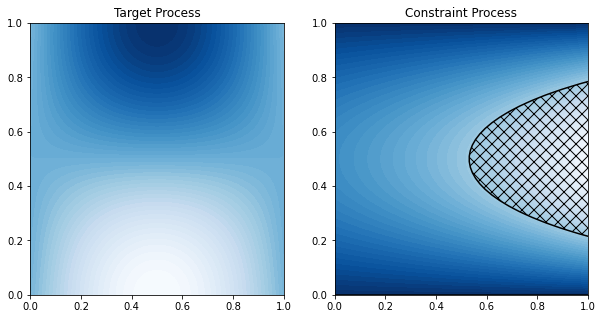

In [4]:
# visualize the ground truth
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X1, X2, YY.reshape(50, 50), 50, cmap='Blues_r')
ax[0].set_title('Target Process')
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), 50, cmap='Blues_r')
ax[1].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[0, xi, np.inf])
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[0, xi, np.inf], hatches=[None, 'xx', '/'])
ax[1].set_title('Constraint Process')
plt.show()

In [5]:
# experiment setting
n0 = 15
n_max = 30
budget = n_max - n0
n_rep = 10

# default GP
kernel = ConstantKernel() * RBF()
f_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
h_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
# initial dataset using Latin Hypercube Design
X_init = lhd(n0, 2, criterion='maximin')
y_init = f(X_init)
z_init = h(X_init)

# initial training
f_gp.fit(X_init, y_init)
h_gp.fit(X_init, z_init)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, random_state=0)

In [6]:
# active learning
X_train = X_init.copy()
y_train = y_init.copy()
z_train = z_init.copy()

w = 0.5
for  i in range(budget):
    score, score_mat = physcal_integrate(XX, f_gp, h_gp, xi, alpha=1.96, weight=w)
    x_new = np.atleast_2d(XX[np.argmax(score)])
    y_new = f(x_new)
    z_new = h(x_new)
    X_train = np.vstack((X_train, x_new))
    y_train = np.hstack((y_train, y_new))
    z_train = np.hstack((z_train, z_new))
    f_gp.fit(X_train, y_train)
    h_gp.fit(X_train, z_train)
    w = score_mat[:, 1].mean() / score_mat.mean(0).sum()

In [7]:
# count total number of failures
print('Total number of additional failures: %d' %(np.count_nonzero(z_train[n0:] >= xi)))

Total number of additional failures: 0


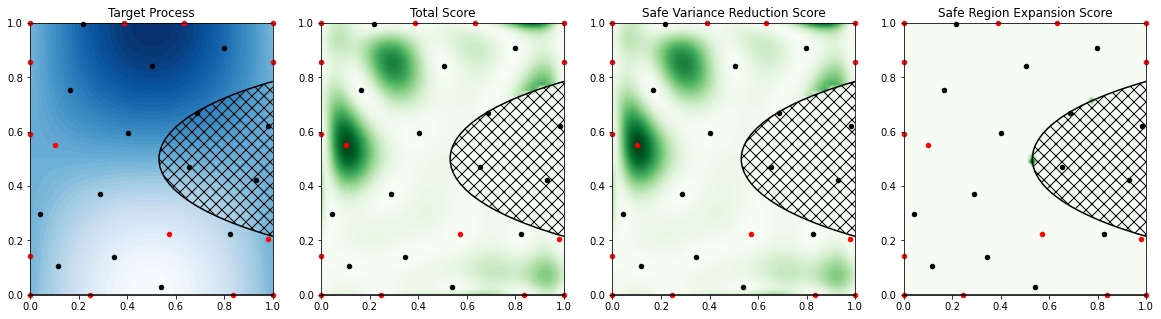

In [8]:
# visualize the result
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].set_title('Target Process')
ax[0].contourf(X1, X2, YY.reshape(50, 50), 50, cmap='Blues_r')
ax[0].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[0].scatter(X_train[15:, 0], X_train[15:, 1], c='r', s=20, clip_on=False)
ax[0].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[0, xi, np.inf])
ax[0].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[0, xi, np.inf], hatches=[None, 'xx', '/'])

ax[1].set_title('Total Score')
ax[1].contourf(X1, X2, score.reshape(50, 50), 50, cmap='Greens')
ax[1].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[1].scatter(X_train[15:, 0], X_train[15:, 1], c='r', s=20, clip_on=False)
ax[1].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[0, xi, np.inf])
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[0, xi, np.inf], hatches=[None, 'xx', '/'])

ax[2].set_title('Safe Variance Reduction Score')
ax[2].contourf(X1, X2, score_mat[:, 0].reshape(50, 50), 50, cmap='Greens')
ax[2].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[2].scatter(X_train[15:, 0], X_train[15:, 1], c='r', s=20, clip_on=False)
ax[2].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[0, xi, np.inf])
ax[2].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[0, xi, np.inf], hatches=[None, 'xx', '/'])

ax[3].set_title('Safe Region Expansion Score')
ax[3].contourf(X1, X2, score_mat[:, 1].reshape(50, 50), 50, cmap='Greens')
ax[3].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[3].scatter(X_train[15:, 0], X_train[15:, 1], c='r', s=20, clip_on=False)
ax[3].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[0, xi, np.inf])
ax[3].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[0, xi, np.inf], hatches=[None, 'xx', '/'])
plt.show()